In [13]:
# | default_exp crp
%load_ext autoreload
%autoreload 2

# Lag-CRP Analysis


The **Lag-Conditional Response Probability (Lag-CRP)** analysis is a technique commonly used in memory research, particularly in free recall tasks, to measure the lag-contiguity effect: the tendency to recall items studied close together in time, rather than randomly or far apart. 

A key concept in Lag-CRP analysis is the "serial lag," which refers to positional distance between two items during the **study phase**. The Lag-CRP analysis considers serial lags between successively recalled items during the **recall phase**. At each recall position beyond the first, serial lag = (position of current recalled item) − (position of previously recalled item). 

For example, recalling the item studied in position 5 immediately after recalling the item studied in position 4 is a lag of +1. Negative lag indicates recalling an earlier-studied item, positive lag indicates recalling a later-studied item.

The lag-CRP measures the probability of recalling an item at a particular lag **given the current recall position**, conditional on items that remain available for recall. By this definition, the lag-CRP is calculated by tabulating for each recall transition:

- **Actual transitions**: Number of times participants transitioned from recalling item at position X to recalling item at position Y.
- **Available transitions**: Number of times each possible transition lag (Y - X) could have occurred, given the items that had not yet been recalled.
- **Lag-CRP**: Actual transitions divided by available transitions for each lag.

Thus the formula for calculating Lag-CRP across a set of trials is:

$$\text{CRP(Lag)} = \frac{\text{Actual Transitions at Lag}}{\text{Available Transitions at Lag}}$$

High CRP at small lags (especially ±1, ±2) indicates strong temporal contiguity effects: participants recall items studied near each other.

Lag-CRP curves usually show a peak around lag = +1 or −1 and decrease gradually as lags increase, indicating a strong association between temporally adjacent items.

In [1]:
# | exports
from typing import Optional, Sequence

from jax import jit, lax, vmap
from jax import numpy as jnp
from matplotlib import rcParams  # type: ignore
from matplotlib.axes import Axes
from simple_pytree import Pytree

from jaxcmr.experimental.plotting import init_plot, plot_data, set_plot_labels
from jaxcmr.experimental.repetition import all_study_positions
from jaxcmr.helpers import apply_by_subject
from jaxcmr.typing import Array, Bool, Float, Int_, Integer

## Simple Case: When Study Lists are Uniform
To introduce how to calculate Lag-CRP, we will first consider a simple case where the study lists are uniform (no repeated items). In this case, we initialize for each trial a `Tabulation` object that updates at each recall attempt to track the following:

- The last item recalled 
- The number of available items for recall 
- the number of actual transitions made for each lag at each recall attempt
- the number available transitions for each lag at each recall attempt

In [2]:
# | exports


class SimpleTabulation(Pytree):
    "A simple tabulation of transitions between items during recall of a study list."

    def __init__(self, list_length: int, first_recall: Int_):
        self.lag_range = list_length - 1
        self.list_length = list_length
        self.all_items = jnp.arange(1, list_length + 1, dtype=int)
        self.actual_transitions = jnp.zeros(self.lag_range * 2 + 1, dtype=int)
        self.avail_transitions = jnp.zeros(self.lag_range * 2 + 1, dtype=int)
        self.avail_items = jnp.ones(list_length, dtype=bool)
        self.avail_items = self.avail_items.at[first_recall - 1].set(False)
        self.previous_item = first_recall

    def _update(self, current_item: Int_) -> "SimpleTabulation":
        "Tabulate actual and possible serial lags of current from previous item."
        actual_lag = current_item - self.previous_item + self.lag_range
        all_lags = self.all_items - self.previous_item + self.lag_range

        return self.replace(
            previous_item=current_item,
            avail_items=self.avail_items.at[current_item - 1].set(False),
            avail_transitions=self.avail_transitions.at[all_lags].add(self.avail_items),
            actual_transitions=self.actual_transitions.at[actual_lag].add(1),
        )

    def update(self, choice: Int_) -> "SimpleTabulation":
        "Tabulate a transition if the choice is non-zero (i.e., a valid item)."
        return lax.cond(choice > 0, lambda: self._update(choice), lambda: self)

To calculate the Lag-CRP, we tabulate available and actual transitions for each lag at each recall attempt in applicable trials:

In [3]:
# | exports


def simple_tabulate_trial(
    trial: Integer[Array, " recall_events"], list_length: int
) -> SimpleTabulation:
    "Tabulate transitions across a single trial."
    return lax.scan(
        lambda tabulation, recall: (tabulation.update(recall), None),
        SimpleTabulation(list_length, trial[0]),
        trial[1:],
    )[0]

Finally, we aggregate the counts of actual and available transitions across all trials, and divide the actual transitions by the available transitions to get the Lag-CRP for each lag.

In [4]:
# | exports


def simple_crp(
    trials: Integer[Array, "trials recall_events"], list_length: int
) -> Float[Array, " lags"]:
    "Tabulate transitions for multiple trials."
    tabulated_trials = lax.map(lambda t: simple_tabulate_trial(t, list_length), trials)
    total_actual_transitions = jnp.sum(tabulated_trials.actual_transitions, axis=0)
    total_possible_transitions = jnp.sum(tabulated_trials.avail_transitions, axis=0)
    return total_actual_transitions / total_possible_transitions


This approach forms the basis for more complex transition analyses that are used in practice, such as when study lists are not uniform (e.g., when items are repeated) or when only particular transitions are of interest (e.g., from just the first recall position) or when transition counts are binned by distance measures instead of serial lag. 

## Extension: When Study Lists Have Repeated Items
Now we consider the scenario where the study lists are not uniform, meaning that items can be repeated. 

If items can be repeated within the same study list, values in our 2-D `recalls` can only indicate one of the study positions of the recalled item.
To account for this, we additionally use a 2-D `presentations` array tracking trial by study position for presented items.
A helper function `all_study_positions` is mapped over a `trial` vector to create a 2-D array of study positions for each recalled item, where the first dimension is the recall position, and the second dimension is the study position.
This makes it possible to track which study positions are available for recall at each recall position, which study positions are actually recalled in a given recall position, as well as which study positions are transitioned *from* and *to* at each recall position.

As with our other analyses addressing study lists with repeated items, we want to count recalls of items with multiple study positions as a single recall of *all* of those study positions.
This implies that our `Tabulation` object needs substantial changes to account for the fact that we are now tracking multiple study positions for each recalled item.

To address this complexity, we devote separate methods to track the four main features that are updated at each recall attempt in `Tabulation.tabulate`:

1. **The last item recalled**. Tabulating the last item recalled is straightforward itself, but we need to ensure that the stored value can be readily mapped to its possibly multiple study positions to support lag calculations. We explicitly update the study positions of the last recalled item at each tabulated recall attempt by indexing `Tabulation.item_study_positions` with the last recalled item.

2. **The number of available items for recall**. We introduce a new method `Tabulation.available_recalls_after` that takes the current recalled item, maps it to each of its study positions, then updates a boolean array of available study positions for recall, `Tabulation.avail_recalls`, setting the recalled study positions to `False` while leaving the rest of the study positions at their current values. This method is called at each tabulated recall attempt.

3. **The number of actual transitions made for each lag at each recall attempt.** In order to track the number of actual transitions made for each lag at each recall attempt, we need the study positions of the last recalled item, as well as the study positions of the current recalled item. We break this down into a two-method job:
   - `Tabulation.lags_from_previous` takes a single study position of the current recalled item and finds the lag from each of the study positions of the last recalled item. It produces a 1-D boolean array of lags, where the index of the lag is the lag value and the value at that index is `True` if that lag was made from the last recalled item to the current recalled item. 
   - `Tabulation.tabulate_actual_lags` finds the study positions of the current recalled item and passes each position to `Tabulation.lags_from_previous` to determine for each study position their lag from each of the study positions of the last recalled item, and finally returns an updated tabulation of all actual transitions made for each lag across all processed recall attempts. 

4. **The number of available transitions for each lag at each recall attempt.** Tracking available lag transitions is similar to tracking actual lag transitions, but requires considering *every* possible transition from the last recalled item that could happen, not just the one(s) that actually did. We similarly break this down into two methods:
   - `Tabulation.available_lags_from` takes a reference study position and uses `Tabulation.avail_recalls` to find all of the available study positions for recall, and then finds the lag from the reference study position to each of the available study positions. It produces a 1-D boolean array of lags, where the index of the lag is the lag value and the value at that index is `True` if that lag was available from the reference study position. 
   - `Tabulation.tabulate_available_lags` finds the study positions of the last recalled item and passes each position to `Tabulation.available_lags_from` to determine for each study position their lag from each of the available study positions, and finally returns an updated tabulation of all available transitions for each lag across all processed recall attempts.

This is a lot of work to do at each recall attempt, but it is necessary to ensure that we are correctly tabulating the available and actual transitions for each lag. 

In [5]:
# | exports


def set_false_at_index(vec: Bool[Array, " positions"], i: Int_):
    return lax.cond(i, lambda: (vec.at[i - 1].set(False), None), lambda: (vec, None))


class Tabulation(Pytree):
    "A tabulation of transitions between items during recall of a study list."

    def __init__(
        self,
        presentation: Integer[Array, " study_events"],
        first_recall: Int_,
        size: int = 3,
    ):
        self.list_length = presentation.size
        self.lag_range = self.list_length - 1
        self.all_positions = jnp.arange(1, self.list_length + 1, dtype=int)
        self.base_lags = jnp.zeros(self.lag_range * 2 + 1, dtype=int)
        self.size = size
        self.item_study_positions = lax.map(
            lambda i: all_study_positions(i, presentation, size),
            self.all_positions,
        )

        self.actual_lags = jnp.zeros(self.lag_range * 2 + 1, dtype=int)
        self.avail_lags = jnp.zeros(self.lag_range * 2 + 1, dtype=int)

        self.previous_positions = self.item_study_positions[first_recall - 1]
        self.avail_recalls = jnp.ones(self.list_length, dtype=bool)
        self.avail_recalls = self.available_recalls_after(first_recall)
    
    # for updating avail_recalls: study positions still available for retrieval
    def available_recalls_after(self, recall: Int_) -> Bool[Array, " positions"]:
        "Update the study positions available to retrieve after a transition."
        study_positions = self.item_study_positions[recall - 1]
        return lax.scan(set_false_at_index, self.avail_recalls, study_positions)[0]

    # for updating actual_lags: lag-transitions actually made from the previous item
    def lags_from_previous(self, pos: Int_) -> Bool[Array, " positions"]:
        "Identify the lag(s) from the study position(s) of the previous item."

        def f(prev):
            return lax.cond(
                (pos * prev) == 0,
                lambda: self.base_lags,
                lambda: self.base_lags.at[pos - prev + self.lag_range].add(1),
            )

        return lax.map(f, self.previous_positions).sum(0).astype(bool)

    def tabulate_actual_lags(self, recall: Int_) -> Integer[Array, " lags"]:
        "Tabulate the actual transition after a transition."
        recall_study_positions = self.item_study_positions[recall - 1]
        new_lags = (
            lax.map(self.lags_from_previous, recall_study_positions).sum(0).astype(bool)
        )
        return self.actual_lags + new_lags

    # for updating avail_lags: lag-transitions available from the previous item
    def available_lags_from(self, pos: Int_) -> Bool[Array, " lags"]:
        "Identify recallable lag transitions from the specified study position."
        return lax.cond(
            pos == 0,
            lambda: self.base_lags,
            lambda: self.base_lags.at[self.all_positions - pos + self.lag_range].add(
                self.avail_recalls
            ),
        )

    def tabulate_available_lags(self) -> Integer[Array, " lags"]:
        "Tabulate available transitions after a transition."
        new_lags = (
            lax.map(self.available_lags_from, self.previous_positions)
            .sum(0)
            .astype(bool)
        )
        return self.avail_lags + new_lags

    # unifying tabulation of actual/avail lags, previous positions, and avail recalls
    def tabulate(self, recall: Int_) -> "Tabulation":
        "Tabulate actual and possible serial lags of current from previous item."
        return lax.cond(
            recall,
            lambda: self.replace(
                previous_positions=self.item_study_positions[recall - 1],
                avail_recalls=self.available_recalls_after(recall),
                actual_lags=self.tabulate_actual_lags(recall),
                avail_lags=self.tabulate_available_lags(),
            ),
            lambda: self,
        )

Just like in our original implementation, we include a `tabulate_trial` method that takes a trial and updates the `Tabulation` object with the actual and available transitions for each lag at each recall attempt. 

In [6]:
# | exports


def tabulate_trial(
    trial: Integer[Array, " recall_events"],
    presentation: Integer[Array, " study_events"],
    size: int = 3,
) -> tuple[Float[Array, " lags"], Float[Array, " lags"]]:
    init = Tabulation(presentation, trial[0], size)
    tab = lax.fori_loop(1, trial.size, lambda i, t: t.tabulate(trial[i]), init)
    return tab.actual_lags, tab.avail_lags

Finally, in our `crp` function, we aggregate the counts of actual and available transitions across all trials, and divide the actual transitions by the available transitions to get the Lag-CRP for each lag.

In [7]:
# | exports


def crp(
    trials: Integer[Array, "trials recall_events"],
    presentations: Integer[Array, "trials study_events"],
    list_length: int,
    size: int = 3,
) -> Float[Array, " lags"]:
    actual, possible = vmap(tabulate_trial, in_axes=(0, 0, None))(
        trials, presentations, size
    )
    return actual.sum(0) / possible.sum(0)

## Plotting

In [8]:
#| exports

def plot_crp(
    datasets: Sequence[dict[str, jnp.ndarray]] | dict[str, jnp.ndarray],
    trial_masks: Sequence[Bool[Array, " trial_count"]] | Bool[Array, " trial_count"],
    max_lag: int = 5,
    distances: Optional[Float[Array, "word_count word_count"]] = None,
    color_cycle: Optional[list[str]] = None,
    labels: Optional[Sequence[str]] = None,
    contrast_name: Optional[str] = None,
    axis: Optional[Axes] = None,
    size: int = 3,
) -> Axes:
    """Returns Axes object with plotted prob of lag-CRP for datasets and trial masks.

    Args:
        datasets: Datasets containing trial data to be plotted.
        trial_masks: Masks to filter trials in datasets.
        max_lag: Maximum lag to plot.
        color_cycle: List of colors for plotting each dataset.
        distances: Unused, included for compatibility with other plotting functions.
        labels: Names for each dataset for legend, optional.
        contrast_name: Name of contrast for legend labeling, optional.
        axis: Existing matplotlib Axes to plot on, optional.
        size: Maximum number of study positions an item can be presented at.
    """
    axis = init_plot(axis)

    if color_cycle is None:
        color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]

    if labels is None:
        labels = [""] * len(datasets)

    if isinstance(datasets, dict):
        datasets = [datasets]

    if isinstance(trial_masks, jnp.ndarray):
        trial_masks = [trial_masks]

    lag_interval = jnp.arange(-max_lag, max_lag + 1, dtype=int)

    for data_index, data in enumerate(datasets):
        lag_range = (jnp.max(data["listLength"]) - 1).item()
        subject_values = apply_by_subject(
            data,
            trial_masks[data_index],
            jit(crp, static_argnames=("size")),
            size,
        )
        subject_values = jnp.vstack(subject_values)
        subject_values = subject_values[
            :, lag_range - max_lag : lag_range + max_lag + 1
        ]

        color = color_cycle.pop(0)
        plot_data(
            axis,
            lag_interval,
            subject_values,
            labels[data_index],
            color,
        )

    set_plot_labels(axis, "Lag", "Conditional Resp. Prob.", contrast_name)
    return axis


## Examples

In [9]:
import os

from jaxcmr.helpers import find_project_root, generate_trial_mask, load_data

/Users/jordangunn/jaxcmr/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)


Array([0.10416666, 0.04166667, 0.02147239, 0.0228833 , 0.01654412,
       0.01880878, 0.01775956, 0.02140309, 0.02038627, 0.01629914,
       0.02      , 0.01670644, 0.01305684, 0.01468532, 0.01878238,
       0.017042  , 0.01747234, 0.01930502, 0.01536831, 0.01510574,
       0.01016949, 0.01390176, 0.01393885, 0.01690507, 0.01760131,
       0.02655569, 0.01942117, 0.0177712 , 0.01956599, 0.02229081,
       0.02253148, 0.02098128, 0.02182163, 0.02749459, 0.02875974,
       0.03524229, 0.05237688, 0.06995769, 0.1551922 ,        nan,
       0.25058603, 0.09483766, 0.06154943, 0.04214095, 0.02825979,
       0.02849873, 0.02509804, 0.02086677, 0.02140078, 0.02180149,
       0.01564345, 0.01611922, 0.01162425, 0.01868557, 0.01537433,
       0.01518288, 0.01601424, 0.01365818, 0.01031716, 0.01069731,
       0.01161344, 0.01133391, 0.01545455, 0.01106833, 0.00858152,
       0.01419558, 0.01462317, 0.013261  , 0.014295  , 0.01597222,
       0.00988593, 0.01417848, 0.01458523, 0.014     , 0.00467

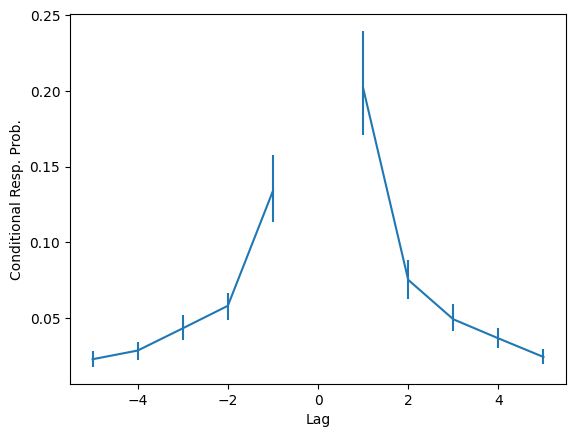

In [10]:
# parameters
run_tag = "CRP"
data_name = "LohnasKahana2014"
data_query = "data['list_type'] == 1"
data_path = os.path.join(find_project_root(), "data/LohnasKahana2014.h5")

# set up data structures
data = load_data(data_path)
recalls = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)

# plot
plot_crp(data, generate_trial_mask(data, data_query))
jit(crp, static_argnames=("size", "list_length"))(recalls[trial_mask], presentations[trial_mask], list_length)

In [11]:
data['recalls'][0]

Array([ 1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 17, 14, 12, 15, 25, 20, 28,
       30, 39, 38, 37, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0], dtype=int32)

In [12]:
data['pres_itemnos'][0]

Array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 12, 13, 14, 15, 16,
       17, 10, 18, 19, 20, 19, 21, 22, 23, 20, 24, 25, 26, 22, 27, 28, 24,
       29, 30, 31, 32, 33, 34], dtype=int32)

Array([0.04968944, 0.053125  , 0.06334842, 0.04145078, 0.04299363,
       0.05462185, 0.06700379, 0.04591265, 0.05876289, 0.04545455,
       0.06233988, 0.053148  , 0.04883721, 0.05703704, 0.05841924,
       0.05555556, 0.05605096, 0.05333333, 0.05128205, 0.06032097,
       0.05402542, 0.06046748, 0.06047198, 0.06941839, 0.06630582,
       0.07769533, 0.07990012, 0.08339953, 0.08632813, 0.12194204,
       0.10481033, 0.15327434, 0.15194109, 0.16762269, 0.18644068,
       0.19298771, 0.2029026 , 0.232496  , 0.2838994 ,        nan,
       0.35789216, 0.2506964 , 0.20603955, 0.21198037, 0.19598393,
       0.18644068, 0.16991802, 0.14376627, 0.13785626, 0.1409376 ,
       0.1046798 , 0.08216113, 0.08366534, 0.07199449, 0.06205674,
       0.05703704, 0.04695191, 0.05190174, 0.04905194, 0.04327131,
       0.03962179, 0.04316888, 0.04470116, 0.03719448, 0.03271292,
       0.03516091, 0.04259377, 0.03353454, 0.02690909, 0.03185703,
       0.02727273, 0.03280142, 0.02967359, 0.02145923, 0.02377

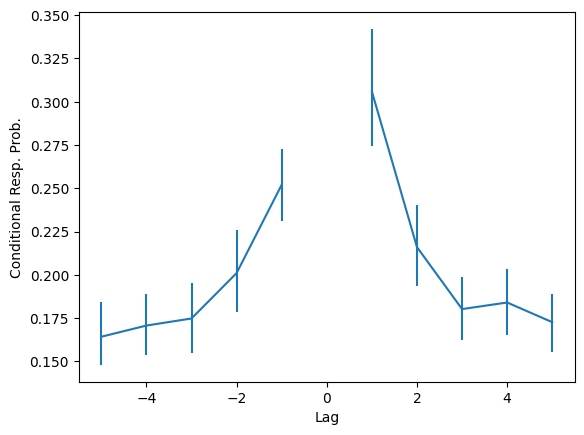

In [18]:
# parameters
run_tag = "CRP"
data_name = "LohnasKahana2014"
data_query = "data['list_type'] == 3"
data_path = os.path.join(find_project_root(), "data/LohnasKahana2014.h5")

# set up data structures
data = load_data(data_path)
recalls = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)

# plot
plot_crp(data, generate_trial_mask(data, data_query))
jit(crp, static_argnames=("size", "list_length"))(recalls[trial_mask], presentations[trial_mask], list_length)